In [ ]:
#| default_exp examples

# examples

> Hand-written example ARC solutions to be used in solver

In order to encourage Claude to respond with solutions in the correct style, it is helpful to provide a few examples and insert them in the conversation history

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from arcsolver.task import *
from dataclasses import dataclass, asdict

In [ ]:
#| export
@dataclass
class Example:
    "Represents an example ARC solution"
    description: str  # Task description
    reasoning: str  # Reasoning process to generate solution code
    new_primitives: str  # Proposed new primitive classes
    input_model: str  # Input grid model
    output_model: str  # Output grid model

    dict = asdict

## 017c7c7b

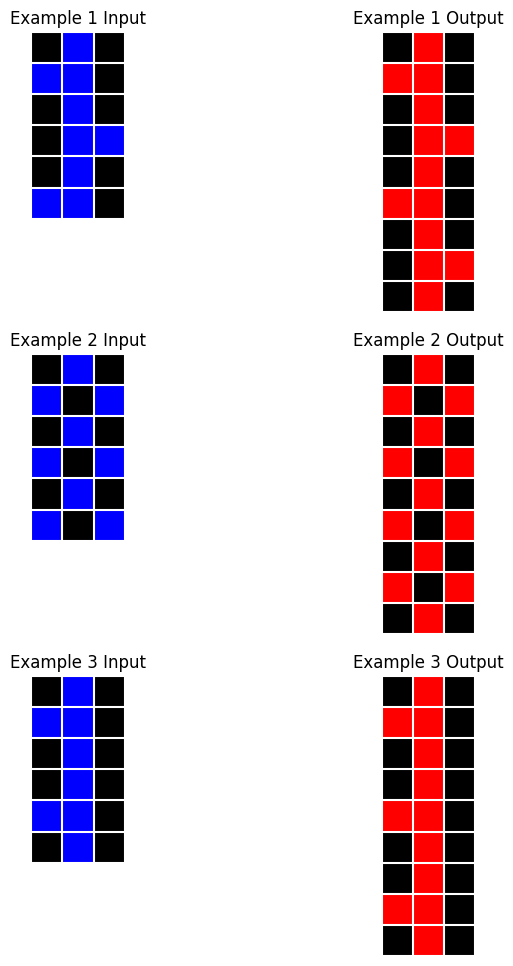

In [ ]:
task = ArcTask('017c7c7b'); task.plot()

In [ ]:
#| exports
example_017c7c7b = Example(
    description="""\
The input grid is a 6x3 grid with a blue colored pattern on a black background. \
The output grid is a 9x3 grid. The first 6 rows of the output grid contain the same pattern as the input grid \
and the additional rows are filled appropriately to form a cyclical or repeating pattern of rows. \
The resulting cyclical patterns in the output grids have varying cycle lengths. \
The color of the entire pattern in the output grid is changed from blue to red. 
""",
    reasoning="""\
1. Pattern & Transformation Analysis:
   - Fixed-size grids: 6x3 input, 9x3 output
   - Single blue pattern on black background transforms to red
   - Pattern extends vertically with cyclic repetition
   - Cycle length varies between examples
   - Two key transformations: cyclic extension and color change (blue → red)

2. Shape Extraction & Representation:
   - Entire grid is one cohesive pattern
   - No need for complex shape extraction
   - Simple Bitmap representation sufficient
   - Background color consistent (black)

3. Required Capabilities:
   - Period detection for cyclic patterns
   - Pattern extension while preserving structure
   - Color transformation (value mapping 1 → 2)
   - No existing primitive handles cyclic patterns

4. Implementation Strategy:
   - Input: Single Bitmap object preserving full grid
   - Output: Detect period, extend pattern, transform color
   - New CyclicPattern primitive needed for:
     * Period detection along specified axis
     * Pattern extension to desired length
     * Integration with existing primitives

5. Edge Cases:
   - Various cycle lengths (1, 2, 3...)
   - Patterns without obvious repetition
   - Full-length cycles

This suggests a solution focusing on pattern-level operations rather than individual shapes, \
with a new CyclicPattern primitive handling the cyclic nature of the transformations. \
The implementation can be straightforward since we're treating each grid as a single pattern, \
with complexity mainly in period detection and extension.
""",
    new_primitives='''\
class CyclicPattern(BaseModel):
    """
    Identify, represent, and manipulate cyclic patterns in ARC task grids,
    particularly for tasks involving pattern repetition and extension.
    """
    data: np.ndarray
    period: int
    axis: int = Field(0, ge=0, le=1)

    model_config = {"arbitrary_types_allowed": True}

    @classmesthod
    def from_array(cls, arr: np.ndarray, axis: int = 0) -> 'CyclicPattern':
        """Create a CyclicPattern instance from a numpy array."""
        return cls(data=arr, period=cls.find_period(arr, axis), axis=axis)

    @staticmethod
    def find_period(arr: np.ndarray, axis: int = 0) -> int:
        """Find the smallest period along a specified axis of a NumPy array."""
        n = arr.shape[axis]
        if n == 0: return 0  # Undefined period for empty axis

        for p in range(1, n):
            pattern = np.take(arr, indices=range(p), axis=axis)
            repeats = int(np.ceil(n / p))
            tiled = np.concatenate([pattern] * repeats, axis=axis)
            slicer = [slice(None)] * arr.ndim
            slicer[axis] = slice(0, n)
            tiled = tiled[tuple(slicer)]

            if np.array_equal(arr, tiled): return p

        return n  # The entire axis if no smaller period is found

    def extend(self, length: int) -> np.ndarray:
        """Extend the pattern to a specified length."""
        pattern = np.take(self.data, range(self.period), axis=self.axis)
        repeats = [1] * self.data.ndim
        repeats[self.axis] = length // self.period + 1
        tiled = np.tile(pattern, repeats)
        slices = [slice(None)] * self.data.ndim
        slices[self.axis] = slice(length)
        return tiled[tuple(slices)]

    def to_array(self) -> np.ndarray:
        """Convert the cyclic pattern to a numpy array."""
        return self.data

    def __len__(self) -> int:
        """Get the length of the pattern along its axis."""
        return self.data.shape[self.axis]\
''',
    input_model='''\
class InputModel(Grid):
    size: Literal[Vector(6, 3)]

    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'InputModel':
        return cls(
            size=Vector(*arr.shape),
            objects=[Bitmap(position=Vector(0, 0), data=arr)]
            )\
''',
    output_model='''\
class OutputModel(Grid):
    size: Literal[Vector(9, 3)]

    @classmethod
    def from_input(cls, input_grid: InputModel) -> 'OutputModel':
        input_pattern = CyclicPattern.from_array(input_grid.objects[0].data, axis=0)
        extended_pattern = input_pattern.extend(9)
        red_pattern = np.where(extended_pattern == 1, 2, 0)
        
        return cls(
            size=Vector(9,3),
            objects=[Bitmap(position=Vector(0, 0), data=red_pattern)]
        )\
'''
)    

## 36d67576

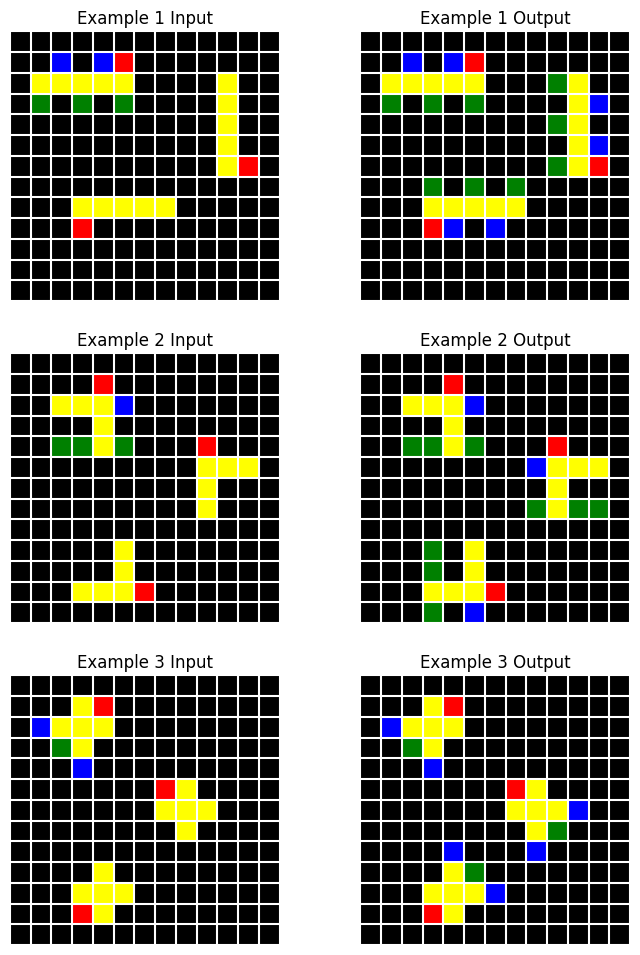

In [ ]:
task = ArcTask('36d67576'); task.plot()

In [ ]:
#| exports
example_36d67576 = Example(
    description='''\
The input grid contains multiple shapes: one complete shape and several partial copies of that shape. \
The partial copies are transformed versions of the complete shape (rotated and/or reflected). \
The task is to identify how each partial shape relates to the complete shape and replace each partial shape \
with its complete transformed version.\
''',
    reasoning='''\
1. Task Analysis:
   - Input contains multiple shapes:
     * One complete reference shape
     * Multiple partial shapes
   - Partial shapes are transformed versions of complete shape
   - Transformations include rotations and reflections
   - Goal: Replace partials with complete transformed versions

2. Shape Identification Requirements:
   - Need to extract contiguous shapes from grid
   - Must distinguish complete from partial shapes
   - First shape extracted is likely complete (largest)
   - ShapeExtractor primitive suitable for this task

3. Transformation Analysis:
   - Need to test all possible transformations:
     * Rotations (0°, 90°, 180°, 270°)
     * Reflections (horizontal, vertical)
     * Transpositions
   - Must match partial shapes allowing for missing parts
   - PatternMatcher with 'allow_extra' mode ideal for this

4. Implementation Strategy:
   - Input Model:
     * Separate complete shape from partials
     * Store as Bitmap objects
     * Use background_color for grid reconstruction
   - Output Model:
     * Generate all possible transformations
     * Find best match for each partial shape
     * Replace partials with complete transformed versions
   
5. Edge Cases:
   - Multiple equally-sized shapes
   - Partial shapes with minimal overlap
   - Ambiguous transformations
   - Different colored shapes

No new primitives needed as existing ones (ShapeExtractor, PatternMatcher, Bitmap) 
provide all required functionality for shape extraction, transformation matching, 
and grid reconstruction.\
''',
    new_primitives='',
    input_model='''\
class InputModel(Grid):
    background_color: Literal[Color(0)] = Color(0)
    full_shape: Bitmap
    partial_shapes: List[Bitmap]

    @model_validator(mode='before')
    def set_objects(cls, values):
        values['objects'] = [values['full_shape']] + values['partial_shapes']
        return values

    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'InputModel':
        arr_mask = (arr != 0).astype(int)
        shape_info = ShapeExtractor.extract_contiguous_regions(arr_mask, 1)
        colored_shapes = []
        for shape, pos in shape_info:
            colored_shapes.append((
                arr[pos[0]:pos[0]+shape.shape[0], pos[1]:pos[1]+shape.shape[1]],
                pos
                ))
        
        full_shape = Bitmap(position=Vector(*colored_shapes[0][1]),
                          data=colored_shapes[0][0])
        partial_shapes = [
            Bitmap(position=Vector(*pos), data=shape) for shape, pos in colored_shapes[1:]
        ]

        return cls(
            size=Vector(*arr.shape),
            full_shape=full_shape,
            partial_shapes=partial_shapes
        )\
''',
    output_model='''\
class OutputModel(Grid):
    @classmethod
    def from_input(cls, input_grid: InputModel) -> 'OutputModel':
        full_shape = input_grid.full_shape.to_array()
        transformations = [
            full_shape,
            np.rot90(full_shape, 1),
            np.rot90(full_shape, 2),
            np.rot90(full_shape, 3),
            np.flip(full_shape, 0),
            np.flip(full_shape, 1),
            full_shape.T,
            np.fliplr(full_shape).T
        ]
        
        new_shapes = []
        for obj in input_grid.partial_shapes:
            # Create a grid with just the partial shape object
            obj_arr = obj.to_array(input_grid.size)
            obj_arr[obj_arr == -1] = 0
            # Find the transformation that best matches the partial shape
            matches = [(t, *PatternMatcher.find_best_match(obj_arr, t, match_type='allow_extra')) for t in transformations]
            best_match = max(matches, key=lambda m: m[-1])  # matches is a list of (transformation, position, overlap_count)
            new_shapes.append(Bitmap(position=best_match[1], data=best_match[0]))
        
        return cls(
            size=input_grid.size,
            background_color=input_grid.background_color,
            objects=[input_grid.full_shape] + new_shapes
        )\
'''
)

## 007bbfb7

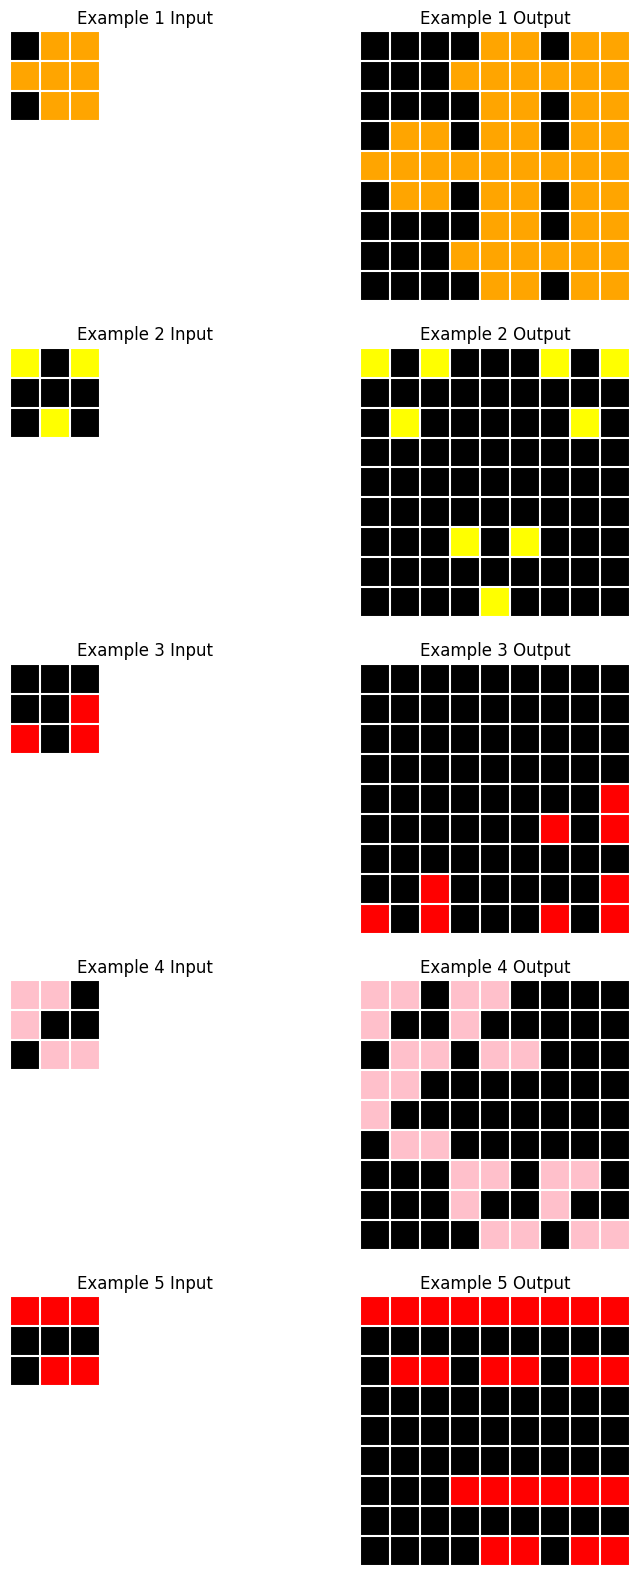

In [ ]:
task = ArcTask('007bbfb7'); task.plot()

In [ ]:
#| exports
example_007bbfb7 = Example(
    description='''\
The input grid is a 3x3 grid with a single-colored pattern on a black background. \
The output grid size is 9x9. Each pixel in the input grid corresponds to a 3x3 section in the output grid. \
For each pixel in the input grid that is colored, its corresponding section of the output grid is filled \
with a copy of the entire input grid.\
''',
    reasoning='''\
1. Pattern Analysis:
   - Input: 3x3 grid with single-colored pattern on black
   - Output: 9x9 grid with recursive pattern structure
   - Each colored pixel in input maps to 3x3 section in output
   - These 3x3 sections contain copies of entire input pattern

2. Transformation Properties:
   - Scale factor is 3 (3x3 → 9x9)
   - Pattern replication follows a specific rule:
     * For each non-zero input pixel
     * Replace with full input pattern
     * For zero pixels, keep as zero
   - This resembles a Kronecker product operation:
     * Binary mask of pattern × Original pattern
     * Will naturally create the required structure

3. Implementation Strategy:
   - Input Model:
     * Single Bitmap sufficient for 3x3 pattern
     * Fixed size constraint (3x3)
   - Output Model:
     * Create binary mask of non-zero elements
     * Apply Kronecker product for pattern replication
     * Result gives correct 9x9 structure

4. Edge Cases:
   - Empty input patterns
   - Single pixel patterns
   - Fully filled patterns
   - Different colors

No new primitives needed as the transformation can be handled efficiently using 
numpy's Kronecker product (kron) operation combined with existing Bitmap primitive.\
''',
    new_primitives='',
    input_model='''\
class InputModel(Grid):
    size: Literal[Vector(3, 3)]
    pattern: Bitmap

    @model_validator(mode='before')
    def set_objects(cls, values):
        values['objects'] = [values['pattern']]
        return values

    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'InputModel':
        return cls(
            size=Vector(*arr.shape),
            pattern=Bitmap(position=Vector(i=0, j=0), data=arr)
        )\
''',
    output_model='''\
class OutputModel(Grid):
    size: Literal[Vector(9, 9)] = Vector(9, 9)

    @classmethod
    def from_input(cls, input_grid: InputModel) -> 'OutputModel':
        input_pattern = input_grid.pattern.data
        binary_mask = (input_pattern != 0).astype(int)
        output_pattern = np.kron(binary_mask, input_pattern)
        
        return cls(
            objects=[Bitmap(position=Vector(0, 0), data=output_pattern)]
        )\
'''
)

In [ ]:
#| exports
examples = [example_017c7c7b, example_36d67576, example_007bbfb7]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()